# Simulator runner

In [71]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [72]:
from utilitysimv2 import InferenceJob, TrainingJob, get_optimus_fn, thief_sco_scheduler, single_camera_optimizer, get_tanh_fn, get_linear_fn, get_tanh_fn, simulator, thief_scheduler, fair_scheduler

In [94]:
def generate_config2(name, final_accuracy, job_time, start_accuracy = 50, inference_job = None):
    if start_accuracy > final_accuracy:
        raise Exception("The model is already trained. start_accuracy {} > final_accuracy {}".format(start_accuracy, final_accuracy))
    # solve a=1 / ((1 / (t * 10 * 1 / (t+d))) + 1) * 100 * K, b=1 / ((1 / ((t+d) * 10 * 1 / (t+d))) + 1) * 100 * K for K, t
    a=start_accuracy
    b=final_accuracy
    d=job_time
    k=11*b/1000
    t=a*d/(1000*k - 11*a)
    conv_time=t+d
    
    func, inv_func = get_optimus_fn(conv_time, k)
    init_time = inv_func(start_accuracy)
    return TrainingJob(name, func, init_time, conv_time, resource_alloc=0, inference_job=inference_job)

def define_workload():
    total_resources = 2
    retraining_period = 200
    start_accuracy_a = 20
    start_accuracy_b = 10

    A_inference = InferenceJob("A_inference", start_accuracy_a, get_linear_fn(1)[0], resource_alloc=0)
    A_training_configs = [generate_config2("A_train_1", 90, 300, start_accuracy_a, inference_job=A_inference),
                       generate_config2("A_train_2", 80, 100, start_accuracy_a, inference_job=A_inference),
                       generate_config2("A_train_3", 30, 50, start_accuracy_a, inference_job=A_inference),
                       generate_config2("A_train_4", 25, 31, start_accuracy_a, inference_job=A_inference)]

    B_inference = InferenceJob("B_inference", start_accuracy_b, get_linear_fn(1)[0], resource_alloc=0)
    B_training_configs = [generate_config2("B_train_1", 90, 300, start_accuracy_b, inference_job=B_inference),
                       generate_config2("B_train_2", 70, 100, start_accuracy_b, inference_job=B_inference),
                       generate_config2("B_train_3", 30, 50, start_accuracy_b, inference_job=B_inference),
                       generate_config2("B_train_4", 80, 30, start_accuracy_b, inference_job=B_inference)]
    
    
    job_pairs = [(A_inference, A_training_configs), (B_inference, B_training_configs)]
    job_db = {j.name: j for j in [A_inference, *A_training_configs, B_inference, *B_training_configs]}
    
    inference_only_alloc = {0: {'A_train_1': 0,
                            'B_train_1': 0,
                            'A_inference': 1,
                            'B_inference': 1}}
    
    return job_pairs, job_db, total_resources, retraining_period, inference_only_alloc

In [147]:
def define_workload_real():
    total_resources = 10
    retraining_period = 400
    start_accuracy_A = 40
    start_accuracy_B = 40

    A_inference = InferenceJob("A_inference", start_accuracy_A, get_linear_fn(1)[0], resource_alloc=0)
    A_training_configs = [generate_config2("train_0", 68.00, 100.92, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_1", 72.00, 51.14, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_2", 75.20, 74.22, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_3", 83.10, 207.44, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_4", 64.70, 17.91, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_5", 87.00, 100.30, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_6", 70.50, 68.04, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_7", 60.90, 26.22, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_8", 58.60, 97.26, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_9", 59.50, 21.76, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_10", 69.80, 44.00, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_11", 68.00, 49.59, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_12", 73.00, 219.19, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_13", 77.80, 125.70, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_14", 62.80, 64.54, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_15", 67.90, 53.29, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_16", 69.20, 23.23, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_17", 84.60, 201.70, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_18", 83.50, 211.34, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_19", 61.10, 18.02, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_20", 69.30, 24.61, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_21", 63.80, 26.49, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_22", 56.20, 16.38, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_23", 64.60, 19.09, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_24", 65.20, 46.56, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_25", 76.70, 30.91, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_26", 69.50, 52.43, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_27", 58.30, 25.39, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_28", 75.20, 34.01, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_29", 63.30, 40.14, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_30", 68.70, 48.39, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_31", 77.40, 108.93, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_32", 84.00, 186.64, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_33", 70.20, 39.01, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_34", 65.60, 28.55, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_35", 50.20, 15.00, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_36", 86.50, 110.82, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_37", 56.30, 53.75, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_38", 58.70, 38.64, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_39", 53.80, 33.42, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_40", 74.50, 269.82, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_41", 74.80, 87.55, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_42", 78.00, 50.23, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_43", 54.80, 19.12, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_44", 86.30, 125.32, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_45", 57.30, 31.06, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_46", 75.30, 78.57, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_47", 76.80, 141.83, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_48", 79.80, 200.14, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_49", 65.50, 28.08, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_50", 75.90, 70.68, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_51", 81.30, 65.21, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_52", 52.10, 21.93, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_53", 75.60, 29.03, start_accuracy_A, inference_job=A_inference),
                        generate_config2("train_54", 59.40, 38.94, start_accuracy_A, inference_job=A_inference)]

    B_inference = InferenceJob("B_inference", start_accuracy_B, get_linear_fn(1)[0], resource_alloc=0)
    B_training_configs = [generate_config2("train_55", 67.60, 137.32, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_56", 65.80, 21.98, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_57", 77.20, 69.87, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_58", 69.10, 22.27, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_59", 59.90, 37.97, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_60", 74.20, 80.85, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_61", 63.10, 33.06, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_62", 60.10, 17.07, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_63", 54.00, 15.59, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_64", 52.20, 56.11, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_65", 86.60, 367.83, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_66", 70.00, 36.71, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_67", 85.10, 112.62, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_68", 70.60, 33.53, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_69", 61.50, 36.86, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_70", 57.60, 16.92, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_71", 77.00, 54.99, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_72", 64.90, 19.71, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_73", 79.00, 77.27, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_74", 70.60, 31.76, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_75", 61.10, 19.18, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_76", 69.50, 20.81, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_77", 57.80, 14.16, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_78", 64.40, 48.67, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_79", 61.40, 21.29, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_80", 61.70, 20.47, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_81", 66.60, 23.37, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_82", 55.80, 42.05, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_83", 54.90, 18.05, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_84", 79.80, 114.54, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_85", 58.50, 52.74, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_86", 59.30, 20.81, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_87", 63.00, 25.47, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_88", 62.00, 42.15, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_89", 75.80, 120.19, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_90", 67.30, 42.25, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_91", 60.80, 58.24, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_92", 70.50, 148.33, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_93", 73.00, 30.98, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_94", 79.50, 121.01, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_95", 71.70, 33.71, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_96", 60.00, 33.52, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_97", 71.70, 57.51, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_98", 78.10, 30.76, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_99", 77.40, 87.95, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_100", 82.60, 222.61, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_101", 65.60, 39.37, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_102", 62.90, 26.53, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_103", 80.60, 236.74, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_104", 51.40, 31.29, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_105", 80.20, 125.89, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_106", 63.50, 22.59, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_107", 57.70, 34.40, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_108", 72.00, 170.99, start_accuracy_B, inference_job=B_inference),
                        generate_config2("train_109", 80.70, 415.04, start_accuracy_B, inference_job=B_inference)]
    
    
    job_pairs = [(A_inference, A_training_configs), (B_inference, B_training_configs)]
    job_db = {j.name: j for j in [A_inference, *A_training_configs, B_inference, *B_training_configs]}
    
    inference_only_alloc = {0: {'train_0': 0,
                            'train_55': 0,
                            'A_inference': 1,
                            'B_inference': 1}}
    
    return job_pairs, job_db, total_resources, retraining_period, inference_only_alloc

## Run comparison

In [148]:
data = {}
allocation = {}

# Fair Scheduler without SCO
job_pairs, job_db, total_resources, retraining_period, inference_only_alloc = define_workload_real()
inference_jobs = [job_db['A_inference'], job_db['B_inference']]
training_jobs = [job_db['train_0'], job_db['train_55']]
period_allocation = fair_scheduler({j.name: j for j in training_jobs},
                                   {j.name: j for j in inference_jobs},
                                   total_resources)
sim = simulator(training_jobs, inference_jobs, total_resources,
                retraining_period=retraining_period, sim_name='main',
                period_allocation = period_allocation)
results = sim.step_till_completion()
data['fair_worst'] = results['meta']['inf_mean_auc']

# Fair Scheduler with SCO
job_pairs, job_db, total_resources, retraining_period, inference_only_alloc = define_workload_real()
training_jobs = []
inference_jobs = []
for inference_job, training_configs in job_pairs: # Find best allocation
    best_trg_config, debug = single_camera_optimizer(training_configs, inference_job, total_resources=total_resources,
                                                 retraining_period=retraining_period,
                                                 training_res_alloc = 0.5,
                                                 inference_res_alloc = 0.5)
    training_jobs.append(next(a for a in training_configs if a.name == best_trg_config.name))
    inference_jobs.append(inference_job)
period_allocation = fair_scheduler({j.name: j for j in training_jobs},
                                   {j.name: j for j in inference_jobs},
                                   total_resources)
sim = simulator(training_jobs, inference_jobs, total_resources,
                retraining_period=retraining_period, sim_name='main',
                period_allocation = period_allocation)
results = sim.step_till_completion()
data['fair_smart'] = results['meta']['inf_mean_auc']
allocation['fair_smart'] = period_allocation

# thief sco Scheduler
job_pairs, job_db, total_resources, retraining_period, inference_only_alloc = define_workload_real()
training_jobs = []
inference_jobs = []
period_allocation = thief_sco_scheduler(job_pairs, total_resources, retraining_period, iterations = 5)
for jobname in period_allocation[0].keys():
    if "inference" in jobname.lower():
        inference_jobs.append(job_db[jobname])
    elif "train" in jobname.lower():
        training_jobs.append(job_db[jobname])
    else:
        raise Exception
sim = simulator(training_jobs, inference_jobs, total_resources, retraining_period=retraining_period,
                period_allocation=period_allocation, sim_name='main')
results = sim.step_till_completion()
data['thief'] = results['meta']['inf_mean_auc']
allocation['thief'] = period_allocation

# Inference only scheduler
job_pairs, job_db, total_resources, retraining_period, inference_only_alloc = define_workload_real()
inference_jobs = [job_db['A_inference'], job_db['B_inference']]
training_jobs = [job_db['train_0'], job_db['train_55']]
sim = simulator(training_jobs, inference_jobs, total_resources, retraining_period=retraining_period,
                scheduling_algo=fair_scheduler, period_allocation=inference_only_alloc, sim_name='main')
results = sim.step_till_completion()
data['inference_only'] = results['meta']['inf_mean_auc']

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
Job train_0 is done.
41
Job train_0 is done.
42
Job train_0 is done.
43
Job train_0 is done.
44
Job train_0 is done.
45
Job train_0 is done.
46
Job train_0 is done.
47
Job train_0 is done.
48
Job train_0 is done.
49
Job train_0 is done.
50
Job train_0 is done.
51
Job train_0 is done.
Job train_55 is done.
52
Job train_0 is done.
Job train_55 is done.
53
Job train_0 is done.
Job train_55 is done.
54
Job train_0 is done.
Job train_55 is done.
55
Job train_0 is done.
Job train_55 is done.
56
Job train_0 is done.
Job train_55 is done.
57
Job train_0 is done.
Job train_55 is done.
58
Job train_0 is done.
Job train_55 is done.
59
Job train_0 is done.
Job train_55 is done.
60
Job train_0 is done.
Job train_55 is done.
61
Job train_0 is done.
Job train_55 is done.
62
Job train_0 is done.
Job train_55 is done.
63
Job train_0 is done.
Job train_55 is done.
64
Job train_0 is done.
Job tr

Job train_55 is done.
219
Job train_0 is done.
Job train_55 is done.
220
Job train_0 is done.
Job train_55 is done.
221
Job train_0 is done.
Job train_55 is done.
222
Job train_0 is done.
Job train_55 is done.
223
Job train_0 is done.
Job train_55 is done.
224
Job train_0 is done.
Job train_55 is done.
225
Job train_0 is done.
Job train_55 is done.
226
Job train_0 is done.
Job train_55 is done.
227
Job train_0 is done.
Job train_55 is done.
228
Job train_0 is done.
Job train_55 is done.
229
Job train_0 is done.
Job train_55 is done.
230
Job train_0 is done.
Job train_55 is done.
231
Job train_0 is done.
Job train_55 is done.
232
Job train_0 is done.
Job train_55 is done.
233
Job train_0 is done.
Job train_55 is done.
234
Job train_0 is done.
Job train_55 is done.
235
Job train_0 is done.
Job train_55 is done.
236
Job train_0 is done.
Job train_55 is done.
237
Job train_0 is done.
Job train_55 is done.
238
Job train_0 is done.
Job train_55 is done.
239
Job train_0 is done.
Job train_55 

393
Job train_0 is done.
Job train_55 is done.
394
Job train_0 is done.
Job train_55 is done.
395
Job train_0 is done.
Job train_55 is done.
396
Job train_0 is done.
Job train_55 is done.
397
Job train_0 is done.
Job train_55 is done.
398
Job train_0 is done.
Job train_55 is done.
399
Job train_0 is done.
Job train_55 is done.
400
Job train_0 is done.
Job train_55 is done.
401
Simulator steps done.
1
2
3
4
5
6
7
8
9
10
11
12
Job train_25 is done.
Job train_98 is done.
13
Job train_98 is done.
Job train_25 is done.
14
Job train_98 is done.
Job train_25 is done.
15
Job train_98 is done.
Job train_25 is done.
16
Job train_98 is done.
Job train_25 is done.
17
Job train_98 is done.
Job train_25 is done.
18
Job train_98 is done.
Job train_25 is done.
19
Job train_98 is done.
Job train_25 is done.
20
Job train_98 is done.
Job train_25 is done.
21
Job train_98 is done.
Job train_25 is done.
22
Job train_98 is done.
Job train_25 is done.
23
Job train_98 is done.
Job train_25 is done.
24
Job tra

176
Job train_98 is done.
Job train_25 is done.
177
Job train_98 is done.
Job train_25 is done.
178
Job train_98 is done.
Job train_25 is done.
179
Job train_98 is done.
Job train_25 is done.
180
Job train_98 is done.
Job train_25 is done.
181
Job train_98 is done.
Job train_25 is done.
182
Job train_98 is done.
Job train_25 is done.
183
Job train_98 is done.
Job train_25 is done.
184
Job train_98 is done.
Job train_25 is done.
185
Job train_98 is done.
Job train_25 is done.
186
Job train_98 is done.
Job train_25 is done.
187
Job train_98 is done.
Job train_25 is done.
188
Job train_98 is done.
Job train_25 is done.
189
Job train_98 is done.
Job train_25 is done.
190
Job train_98 is done.
Job train_25 is done.
191
Job train_98 is done.
Job train_25 is done.
192
Job train_98 is done.
Job train_25 is done.
193
Job train_98 is done.
Job train_25 is done.
194
Job train_98 is done.
Job train_25 is done.
195
Job train_98 is done.
Job train_25 is done.
196
Job train_98 is done.
Job train_25 i

347
Job train_98 is done.
Job train_25 is done.
348
Job train_98 is done.
Job train_25 is done.
349
Job train_98 is done.
Job train_25 is done.
350
Job train_98 is done.
Job train_25 is done.
351
Job train_98 is done.
Job train_25 is done.
352
Job train_98 is done.
Job train_25 is done.
353
Job train_98 is done.
Job train_25 is done.
354
Job train_98 is done.
Job train_25 is done.
355
Job train_98 is done.
Job train_25 is done.
356
Job train_98 is done.
Job train_25 is done.
357
Job train_98 is done.
Job train_25 is done.
358
Job train_98 is done.
Job train_25 is done.
359
Job train_98 is done.
Job train_25 is done.
360
Job train_98 is done.
Job train_25 is done.
361
Job train_98 is done.
Job train_25 is done.
362
Job train_98 is done.
Job train_25 is done.
363
Job train_98 is done.
Job train_25 is done.
364
Job train_98 is done.
Job train_25 is done.
365
Job train_98 is done.
Job train_25 is done.
366
Job train_98 is done.
Job train_25 is done.
367
Job train_98 is done.
Job train_25 i

Iter 0, alloc: {<utilitysimv2.InferenceJob object at 0x7f646b75dba8>: [2.5, 2.5], <utilitysimv2.InferenceJob object at 0x7f646bfbd2e8>: [2.5, 2.5]}
Best config for A_inference: train_5
Best config for B_inference: train_67
Iter 0, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f646b75dba8>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7f646bfbd2e8>: [0.9999999999999999, 3.0]}
Iter 1, alloc: {<utilitysimv2.InferenceJob object at 0x7f646b75dba8>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7f646bfbd2e8>: [0.9999999999999999, 3.0]}
Best config for A_inference: train_5
Best config for B_inference: train_67
Iter 1, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f646b75dba8>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7f646bfbd2e8>: [0.9999999999999999, 3.0]}
Iter 2, alloc: {<utilitysimv2.InferenceJob object at 0x7f646b75dba8>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7f646bfbd2e8>: [0.99

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
Job train_5 is done.
21
Job train_5 is done.
22
Job train_5 is done.
23
Job train_5 is done.
24
Job train_5 is done.
25
Job train_5 is done.
26
Job train_5 is done.
27
Job train_5 is done.
28
Job train_5 is done.
29
Job train_5 is done.
30
Job train_5 is done.
31
Job train_5 is done.
Job train_67 is done.
32
Job train_67 is done.
Job train_5 is done.
33
Job train_67 is done.
Job train_5 is done.
34
Job train_67 is done.
Job train_5 is done.
35
Job train_67 is done.
Job train_5 is done.
36
Job train_67 is done.
Job train_5 is done.
37
Job train_67 is done.
Job train_5 is done.
38
Job train_67 is done.
Job train_5 is done.
39
Job train_67 is done.
Job train_5 is done.
40
Job train_67 is done.
Job train_5 is done.
41
Job train_67 is done.
Job train_5 is done.
42
Job train_67 is done.
Job train_5 is done.
43
Job train_67 is done.
Job train_5 is done.
44
Job train_67 is done.
Job train_5 is done.
45
Job train_67 is done.
Job train_5 is done

Iter 4, final_alloc: {<utilitysimv2.InferenceJob object at 0x7f646b75dba8>: [1.0999999999999999, 4.9], <utilitysimv2.InferenceJob object at 0x7f646bfbd2e8>: [0.9999999999999999, 3.0]}


Job train_5 is done.
184
Job train_67 is done.
Job train_5 is done.
185
Job train_67 is done.
Job train_5 is done.
186
Job train_67 is done.
Job train_5 is done.
187
Job train_67 is done.
Job train_5 is done.
188
Job train_67 is done.
Job train_5 is done.
189
Job train_67 is done.
Job train_5 is done.
190
Job train_67 is done.
Job train_5 is done.
191
Job train_67 is done.
Job train_5 is done.
192
Job train_67 is done.
Job train_5 is done.
193
Job train_67 is done.
Job train_5 is done.
194
Job train_67 is done.
Job train_5 is done.
195
Job train_67 is done.
Job train_5 is done.
196
Job train_67 is done.
Job train_5 is done.
197
Job train_67 is done.
Job train_5 is done.
198
Job train_67 is done.
Job train_5 is done.
199
Job train_67 is done.
Job train_5 is done.
200
Job train_67 is done.
Job train_5 is done.
201
Job train_67 is done.
Job train_5 is done.
202
Job train_67 is done.
Job train_5 is done.
203
Job train_67 is done.
Job train_5 is done.
204
Job train_67 is done.
Job train_5 i

358
Job train_67 is done.
Job train_5 is done.
359
Job train_67 is done.
Job train_5 is done.
360
Job train_67 is done.
Job train_5 is done.
361
Job train_67 is done.
Job train_5 is done.
362
Job train_67 is done.
Job train_5 is done.
363
Job train_67 is done.
Job train_5 is done.
364
Job train_67 is done.
Job train_5 is done.
365
Job train_67 is done.
Job train_5 is done.
366
Job train_67 is done.
Job train_5 is done.
367
Job train_67 is done.
Job train_5 is done.
368
Job train_67 is done.
Job train_5 is done.
369
Job train_67 is done.
Job train_5 is done.
370
Job train_67 is done.
Job train_5 is done.
371
Job train_67 is done.
Job train_5 is done.
372
Job train_67 is done.
Job train_5 is done.
373
Job train_67 is done.
Job train_5 is done.
374
Job train_67 is done.
Job train_5 is done.
375
Job train_67 is done.
Job train_5 is done.
376
Job train_67 is done.
Job train_5 is done.
377
Job train_67 is done.
Job train_5 is done.
378
Job train_67 is done.
Job train_5 is done.
379
Job train

In [126]:
# Fair Scheduler with SCO
job_pairs, job_db, total_resources, retraining_period, inference_only_alloc = define_workload()
total_resources = 3
training_jobs = []
inference_jobs = []
for inference_job, training_configs in job_pairs: # Find best allocation
    best_trg_config, debug = single_camera_optimizer(training_configs, inference_job, total_resources=total_resources,
                                                 retraining_period=retraining_period,
                                                 training_res_alloc = total_resources/2,
                                                 inference_res_alloc =  total_resources/2)
    training_jobs.append(next(a for a in training_configs if a.name == best_trg_config.name))
    inference_jobs.append(inference_job)
period_allocation = fair_scheduler({j.name: j for j in training_jobs},
                                   {j.name: j for j in inference_jobs},
                                   total_resources)
sim = simulator(training_jobs, inference_jobs, total_resources,
                retraining_period=retraining_period, sim_name='main',
                period_allocation = period_allocation)
results = sim.step_till_completion()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
Job B_train_4 is done.
40
Job B_train_4 is done.
41
Job B_train_4 is done.
42
Job B_train_4 is done.
43
Job B_train_4 is done.
44
Job B_train_4 is done.
45
Job B_train_4 is done.
46
Job B_train_4 is done.
47
Job B_train_4 is done.
48
Job B_train_4 is done.
49
Job B_train_4 is done.
50
Job B_train_4 is done.
51
Job B_train_4 is done.
52
Job B_train_4 is done.
53
Job B_train_4 is done.
54
Job B_train_4 is done.
55
Job B_train_4 is done.
56
Job B_train_4 is done.
57
Job B_train_4 is done.
58
Job B_train_4 is done.
59
Job B_train_4 is done.
60
Job B_train_4 is done.
61
Job B_train_4 is done.
62
Job B_train_4 is done.
63
Job B_train_4 is done.
64
Job B_train_4 is done.
65
Job B_train_4 is done.
66
Job B_train_4 is done.
67
Job B_train_4 is done.
68
Job B_train_4 is done.
69
Job B_train_4 is done.
70
Job B_train_4 is done.
71
Job B_train_4 is done.
72
Job B_train_4 is done.
73
Job B_tr

In [127]:
print(results['meta']['inf_mean_auc'])

56.23714503012498


In [149]:
period_allocation

{0: {'train_5': 4.9,
  'train_67': 3.0,
  'A_inference': 1.0999999999999999,
  'B_inference': 0.9999999999999999},
 20.469387755102037: {'train_5': 0,
  'train_67': 4.633333333333334,
  'A_inference': 2.7333333333333334,
  'B_inference': 2.6333333333333333},
 31.52230215827338: {'train_67': 0,
  'train_5': 0,
  'A_inference': 5.050000000000001,
  'B_inference': 4.95}}

In [150]:
data

{'fair_worst': 64.8315684272963,
 'fair_smart': 77.036650217514,
 'thief': 83.5478430438286,
 'inference_only': 40.0}

In [151]:
allocation

{'fair_smart': {0: {'train_25': 2.5,
   'train_98': 2.5,
   'A_inference': 2.5,
   'B_inference': 2.5},
  12.303999999999998: {'train_98': 0,
   'train_25': 3.3333333333333335,
   'A_inference': 3.3333333333333335,
   'B_inference': 3.3333333333333335},
  12.348999999999998: {'train_98': 0,
   'train_25': 0,
   'A_inference': 5.0,
   'B_inference': 5.0}},
 'thief': {0: {'train_5': 4.9,
   'train_67': 3.0,
   'A_inference': 1.0999999999999999,
   'B_inference': 0.9999999999999999},
  20.469387755102037: {'train_5': 0,
   'train_67': 4.633333333333334,
   'A_inference': 2.7333333333333334,
   'B_inference': 2.6333333333333333},
  31.52230215827338: {'train_67': 0,
   'train_5': 0,
   'A_inference': 5.050000000000001,
   'B_inference': 4.95}}}

In [6]:
data_instacp={'fair_worst': 29.690015550093747,
 'fair_smart': 50.643793494072995,
 'thief': 65.95741850672249,
 'inference_only': 15.000000000000002}

data_nocp={'fair_worst': 7.5,
 'fair_smart': 39.031395653312515,
 'thief': 51.776637679714945,
 'inference_only': 15.0}

# Visualization

### Comparison

<IPython.core.display.Javascript object>


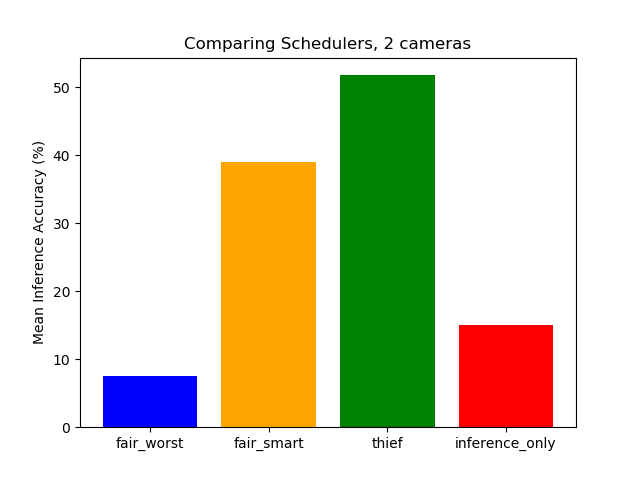

([<matplotlib.axis.XTick at 0x7f49b0eef8d0>,
 <a list of 4 Text xticklabel objects>)

In [45]:
plt.ylabel('Mean Inference Accuracy (%)')
plt.title('Comparing Schedulers, 2 cameras')
plt.bar(range(len(data)), list(data.values()), align='center',  color=['blue', 'orange', 'green', 'red'])
plt.xticks(range(len(data)), list(data.keys()))

In [9]:
data_instacp={'fair_worst': 29.690015550093747,
 'fair_smart': 50.643793494072995,
 'thief': 65.95741850672249,
 'inference_only': 15.000000000000002}

data_nocp={'fair_worst': 7.5,
 'fair_smart': 39.031395653312515,
 'thief': 51.776637679714945,
 'inference_only': 15.0}

combined_data = {k: [data_instacp[k], data_nocp[k]] for k in data_instacp}
print(combined_data)

{'fair_worst': [29.690015550093747, 7.5], 'fair_smart': [50.643793494072995, 39.031395653312515], 'thief': [65.95741850672249, 51.776637679714945], 'inference_only': [15.000000000000002, 15.0]}


<IPython.core.display.Javascript object>


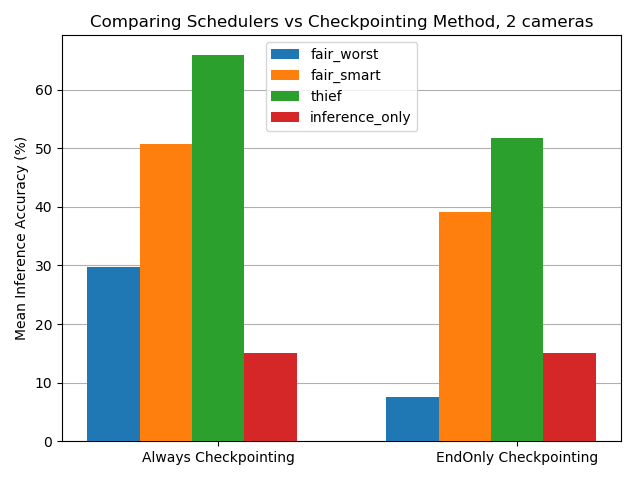

In [29]:
import numpy as np

labels = ['Always Checkpointing', 'EndOnly Checkpointing'] # [5, 30, 200], [150, 300, 200]

x = np.arange(len(labels))  # the label locations

num_bars = len(combined_data.keys())
width = 0.7/num_bars
x_pos = np.arange(-1*num_bars*width/2, num_bars*width/2, width)

fig, ax = plt.subplots()
for i, (label, values) in enumerate(combined_data.items()):
    ax.bar(x + x_pos[i], values, width, label=label, zorder=3)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean Inference Accuracy (%)')
ax.set_title('Comparing Schedulers vs Checkpointing Method, 2 cameras')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

fig.tight_layout()
plt.grid(axis='y', zorder=0)

plt.show()

### Accuracy progression

Text(0, 0.5, 'Accuracy')

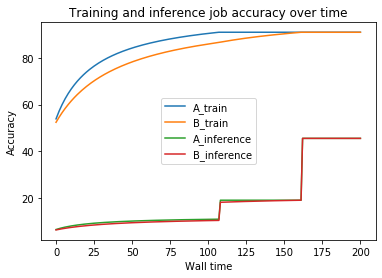

In [8]:
plt.figure()
for job, result in results.items():
    if job != 'meta':
        t, acc = list(zip(*result))
        plt.plot(t, acc, label=job.name)
plt.title("Training and inference job accuracy over time")
plt.legend()
plt.xlabel("Wall time")
plt.ylabel("Accuracy")

In [ ]:
for t, allocation in sim.period_allocation.items():
    names = []
    allocs = []
    for j, alloc in allocation.items():
        allocs.append(alloc)
        names.append(j.name)
    print(names, allocs)
    plt.figure()
    plt.pie(allocs, labels=names, autopct='%1.1f%%',
        shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.title("Allocation at t = {}".format(t))

In [ ]:
means = []
for j, result in results.items():
    if isinstance(j, InferenceJob):
        mean_accuracy = sum(r[1] for r in result)/len(result)
        means.append(mean_accuracy)
MEAN_AUC = sum(means)/len(means)
print("Mean Inference Accuracy across all jobs: {}".format(MEAN_AUC))

In [ ]:
results['meta']